In [ ]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

df = pd.read_csv('annotations_with_depth.csv')

# Area of BB
df['area'] = (df['xbr'] - df['xtl']) * (df['ybr'] - df['ytl'])

# Normalize the features
scaler = RobustScaler()
df['area'] = scaler.fit_transform(df[['area']])
df['depth'] = scaler.fit_transform(df[['depth']])
df['feature'] = df['area']/(df['depth']**2)


# Keeping only area and depth as features rn
df = df.drop(columns=['ripe', 'raw'])
print(df.head())
df.to_csv("1.csv", index=False)

  image_name     xtl     ytl     xbr     ybr  small  medium  large     depth  \
0   i100.jpg   88.12   96.68  140.07  180.90  False    True  False  0.803690   
1   i100.jpg   89.77  136.31  149.25  225.00  False   False   True  1.142723   
2   i100.jpg  132.19   80.20  175.90  151.60  False    True  False  1.199320   
3   i100.jpg  140.07   94.53  200.63  208.83  False   False   True  1.073345   
4   i100.jpg  188.45   73.75  209.59  107.79   True   False  False  0.019038   

       area     feature  
0  1.142946    1.769492  
1  1.436450    1.100040  
2  0.733911    0.510239  
3  1.973442    1.712953  
4 -0.049141 -135.574903  


In [ ]:
from sklearn.model_selection import train_test_split

features = df[['area', 'depth']]
target = df[['small', 'medium', 'large']]

# Train on 80%
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)


Training features shape: (233, 2)
Testing features shape: (59, 2)


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
rf_classifier.fit(X_train, y_train)

# Test (To be checked on yathu, ishaan, smit portion)
y_pred = rf_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Tried XGBoost -> 61%
# Neural network 50 epochs -> 64.41%

Accuracy: 71.19%


# Feature Engineering

In [ ]:
# Calculate aspect ratio
df['aspect_ratio'] = (df['xbr'] - df['xtl']) / (df['ybr'] - df['ytl'])

# Calculate center coordinates
df['center_x'] = (df['xtl'] + df['xbr']) / 2
df['center_y'] = (df['ytl'] + df['ybr']) / 2

# Check the first few rows to confirm the new features are added
print(df[['image_name', 'aspect_ratio', 'center_x', 'center_y']].head())



  image_name  aspect_ratio  center_x  center_y
0   i100.jpg      0.616837   114.095   138.790
1   i100.jpg      0.670651   119.510   180.655
2   i100.jpg      0.612185   154.045   115.900
3   i100.jpg      0.529834   170.350   151.680
4   i100.jpg      0.621034   199.020    90.770


In [ ]:
# Select the features and target
X = df[['depth', 'aspect_ratio', 'center_x', 'center_y']]  # Add any additional features if needed
y = df[['small', 'medium', 'large']].idxmax(axis=1)  # This will give you the target class based on max value (small/medium/large)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy with New Features: {accuracy_rf * 100:.2f}%")


Random Forest Accuracy with New Features: 72.88%


# RFC to get breakpoints


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Prepare features and target
features = df[['area', 'depth']]  # Assuming 'area' is already computed as (xbr - xtl) * (ybr - ytl)
target = df[['small', 'medium', 'large']].idxmax(axis=1)  # Convert one-hot to single-label

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the RFC
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Test accuracy
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 74.58%


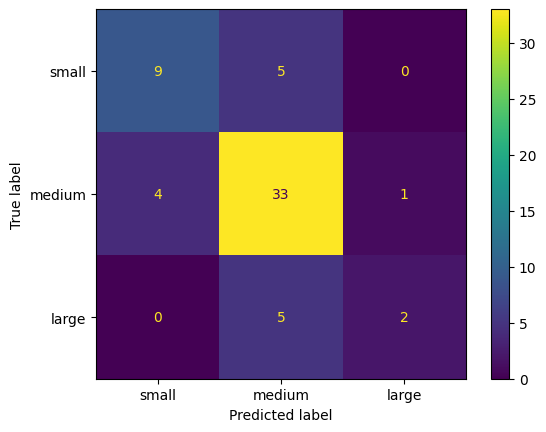

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=['small', 'medium', 'large']), display_labels=['small', 'medium', 'large'])
disp.plot()

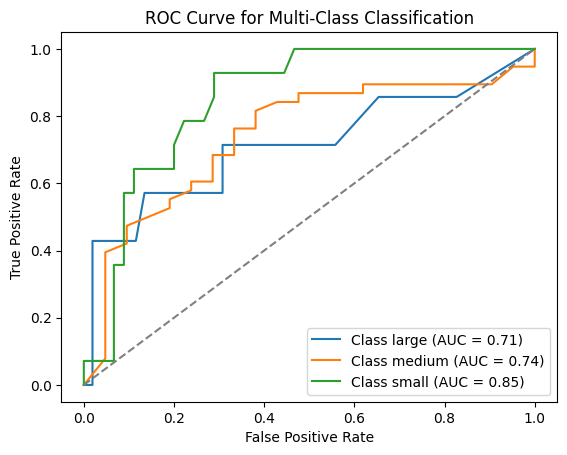

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Binarize the target
y_test_bin = label_binarize(y_test, classes=rfc.classes_)
y_pred_prob = rfc.predict_proba(X_test)

# Plot ROC for each class
for i in range(len(rfc.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {rfc.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='best')
plt.show()


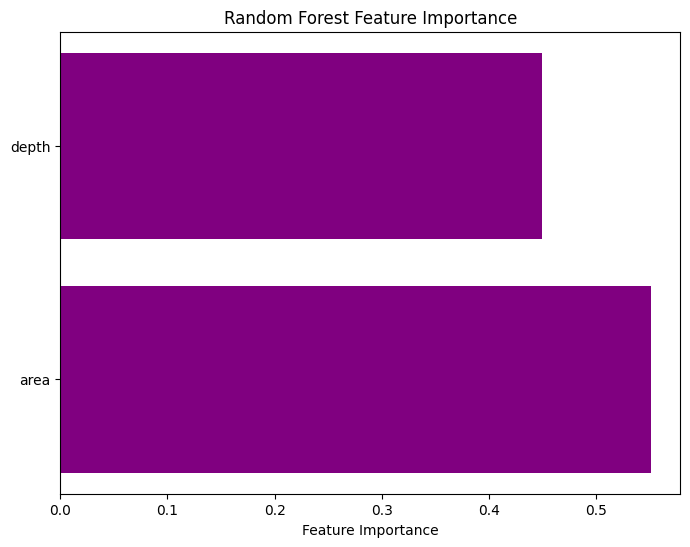

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = rfc.feature_importances_
features = X_train.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='purple')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


In [ ]:
pip install plotly

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)

# Create labels for Sankey diagram (class names)
labels = list(rfc.classes_)

# Initialize source, target, and value lists
sources = []
targets = []
values = []

# Populate the sources, targets, and values for Sankey
for i in range(len(labels)):
    for j in range(len(labels)):
        if cm[i, j] > 0:
            sources.append(i)  # Actual class
            targets.append(j)  # Predicted class
            values.append(cm[i, j])

# Create Sankey diagram
sankey_figure = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
))

sankey_figure.update_layout(title_text="Sankey Diagram of Classification Results", font_size=10)
sankey_figure.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('annotations_with_depth.csv')

# Selecting features and target labels
features = ['area', 'depth']
targets = ['small', 'medium', 'large']  # Multi-label target

# Normalize the features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Splitting the dataset
X = df[features]
y = df[targets]  # Multi-label target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a separate Random Forest model for each label
models = {label: RandomForestClassifier(n_estimators=100, random_state=42) for label in targets}

# Train models
for label in targets:
    models[label].fit(X_train, y_train[label])

# Make predictions
y_pred = pd.DataFrame({label: models[label].predict(X_test) for label in targets})

# Evaluate each label
accuracies = {label: accuracy_score(y_test[label], y_pred[label]) for label in targets}

# Print accuracies
for label, acc in accuracies.items():
    print(f"Accuracy for {label}: {acc:.4f}")



KeyError: "['area'] not in index"

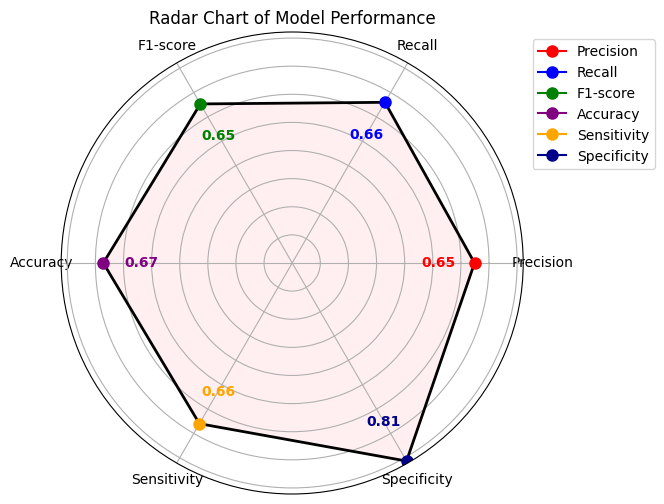

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Confusion matrix values
labels = ['Small', 'Medium', 'Large']
conf_matrix = np.array([
    [29, 7, 3],
    [9, 78, 24],
    [2, 19, 24]
])

# Calculate precision, recall, F1-score, accuracy, sensitivity, specificity
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
sensitivity = recall  # Sensitivity is the same as recall
specificity = []
for i in range(len(labels)):
    tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# Prepare data for radar plot
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'Sensitivity', 'Specificity']
values = [np.mean(precision), np.mean(recall), np.mean(f1_score), accuracy, np.mean(sensitivity), np.mean(specificity)]
num_vars = len(metrics)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Close the radar chart loop

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

# Define colors
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkblue']

# Add data to radar chart
values += values[:1]  # Close the radar chart loop
ax.plot(angles, values, linewidth=2, linestyle='solid', color='black')
ax.fill(angles, values, alpha=0.25, color='pink')

# Add colored points and text at each metric inside the circle
for i in range(num_vars):
    ax.plot(angles[i], values[i], marker='o', markersize=8, color=colors[i], label=metrics[i])
    ax.text(angles[i], values[i] * 0.8, f'{values[i]:.2f}', ha='center', va='center', fontsize=10, color=colors[i], fontweight='bold')

# Configure radar chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_yticklabels([])
ax.set_title("Radar Chart of Model Performance")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.show()

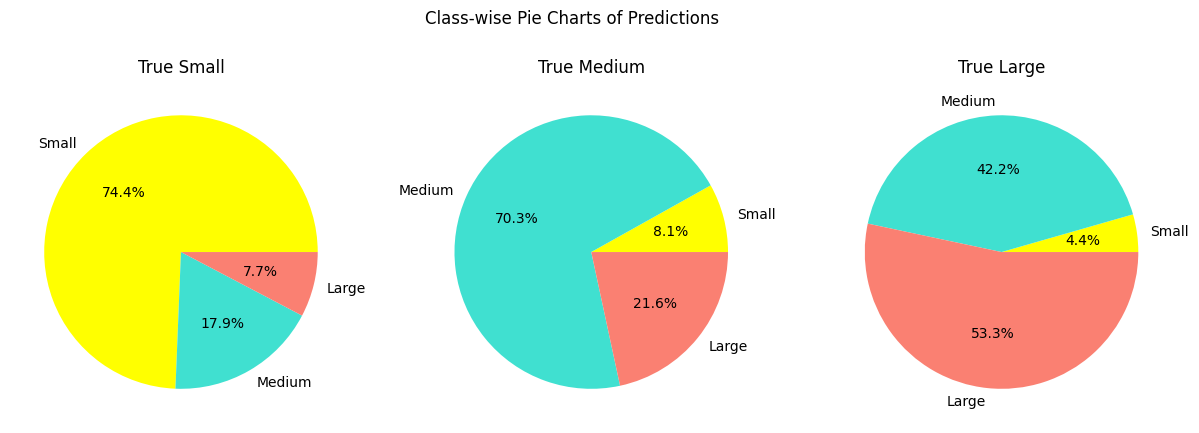

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate(labels):
    axes[i].pie(conf_matrix[i], labels=labels, autopct='%1.1f%%', colors=['yellow', 'turquoise', 'salmon'])
    axes[i].set_title(f'True {label}')

plt.suptitle("Class-wise Pie Charts of Predictions")
plt.show()


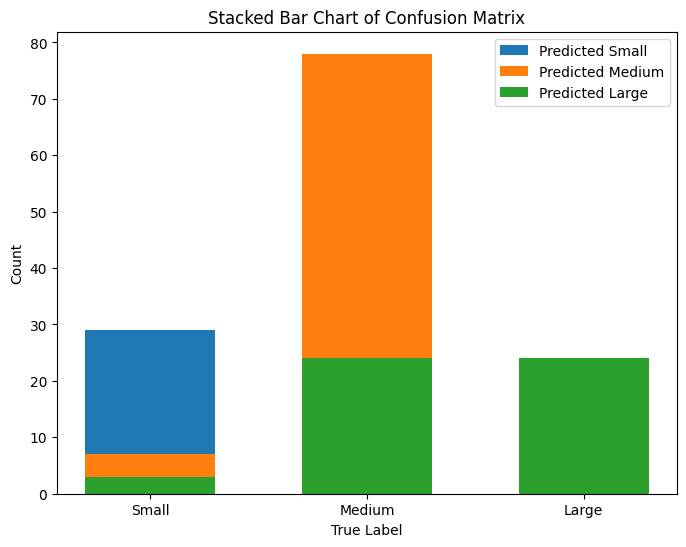

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Small', 'Medium', 'Large']
conf_matrix = np.array([
    [29, 7, 3],
    [9, 78, 24],
    [2, 19, 24]
])

# Transpose the matrix for stacked representation
conf_matrix_T = conf_matrix.T

x = np.arange(len(labels))  # the label locations
width = 0.6  # width of bars

fig, ax = plt.subplots(figsize=(8, 6))

bars = []
for i, label in enumerate(labels):
    bars.append(ax.bar(x, conf_matrix_T[i], width, label=f'Predicted {label}'))

ax.set_xlabel('True Label')
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Chart of Confusion Matrix')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
